# 2D multi-channel interpolation with local slopes regularization

## Author: M.Ravasi

This notebook applies 2D multi-channel interpolation with local slopes regularization to a 2D shot gather of the Missisipi Canyon dataset.

The notebook is organized as follows:

- data pre-processing
- multi-channel slope estimation
- 2D single-channel interpolation with sparsity promoting inversion
- 2D multi-channel interpolation with sparsity promoting inversion
- 2D multi-channel interpolation with sparsity promoting inversion and local slopes regularization.

In [26]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pylops

from pylops.basicoperators import *
from pylops.optimization.sparsity import fista
from pylops.utils.metrics import snr

from mcslopes.nmoinv import NMO
from mcslopes.plotting import plotting_style, plot_reconstruction_2d
from mcslopes.preprocessing import mask, restriction, gradient_data, gradient_nmo_data, fk_filter_design
from mcslopes.slopes import multicomponent_slopes_inverse

plotting_style()
USE_CUPY = True # use cupy or numpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
if USE_CUPY:
    import cupy as cp
    cp_asarray = cp.asarray
    cp_asnumpy = cp.asnumpy
else:
    cp = np
    cp_asarray = np.asarray
    cp_asnumpy = np.asarray

## Parameters

In [28]:
# pre-processing
apply_nmo = True # apply NMO correction prior to interpolation (True) or not (False)
vnmo = 1500 # NMO velocity (in m/s)
mask_thresh = 0.1 # time-space mask threshold
nfft_t, nfft_x = 2**11, 2**9 # lenght of frequency and wavenumber axis (used to compute gradients and perform FK transforms during data reconstruction)

# subsampling
nsub = 5 # subsampling factor

# fk masking
vel = 3200. # velocity
fmax = 70 # maximum frequency
critical = 1.00 # scaling to be applied to the f=k*v line used to create the mask
koffset = 0.002 # shift to be applied to the f=k*v line used to create the mask

# slope estimation
eps_slopeest = 1e3 # regularization factor for smoothing
niter_slopeest = 200 # number of iterations of lsqr

# interpolation
use_secondder = False # use first+second order derivative (True) or just first derivative (False) for interpolation
eps_slopes = 1e1 # regularization factor for slope consistency term
eps_fk = 1e-3 # regularization factor for sparsity term
niter = 200 # number of iterations of fista

In [29]:
# Define dictionaries for solvers
dict_slope_opt = dict(iter_lim=niter_slopeest) if not USE_CUPY else dict(niter=niter_slopeest)

## Data loading and preprocessing

We start by loading the data and applying NMO correction (optional)

In [30]:
# Load data
fload = np.load(f'../../data/gom_data_forsub{nsub}.npz')
f1load = np.load(f'../../data/gom_data_sub{nsub}.npz')
xorig = f1load['xorig']
x = f1load['x']
t = f1load['t']
dt = t[1] - t[0]
dx = xorig[1] - xorig[0]

dataorig = fload['data'].T
gradorig = fload['grad1'].T
data = f1load['data'].T
grad = f1load['grad1'].T

nxorig = xorig.size
nx, nt = x.size, t.size

# Create time gain
gain = (t / 2.)[:, np.newaxis]

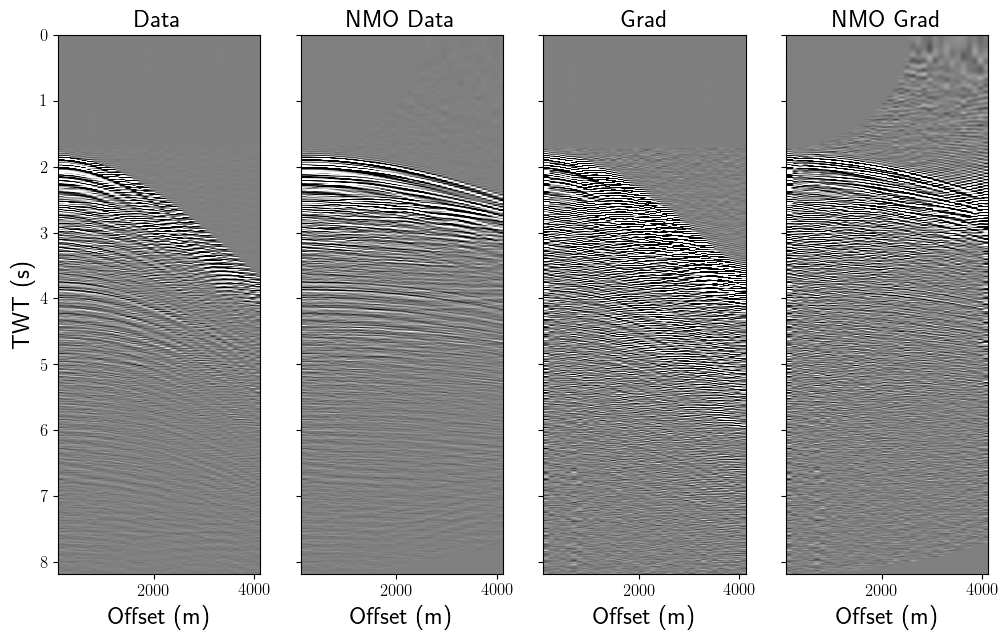

In [31]:
# Apply NMO (optional)
if apply_nmo:
    
    # orig data
    NMOOporig = NMO(t, xorig, vnmo * np.ones(nt))

    dataorignmo = NMOOporig @ dataorig
    gradorignmo = gradient_nmo_data(dataorig, gradorig, t, xorig, vnmo)[0]
    # grad2orignmo = # NOT READY YET!
    
    # subsampled data
    NMOOp = NMO(t, x, vnmo * np.ones(nt))

    datanmo = NMOOp @ data
    gradnmo = gradient_nmo_data(data, grad, t, x, vnmo)[0]
    # grad2nmo = # NOT READY YET! 
    
    fig, axs = plt.subplots(1, 4, sharey=True, figsize=(12, 7))
    axs[0].imshow(data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
    axs[0].set_xlabel('Offset (m)')
    axs[0].set_ylabel('TWT (s)')
    axs[0].set_title('Data')
    axs[0].axis('tight')

    axs[1].imshow(datanmo.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
    axs[1].set_xlabel('Offset (m)')
    axs[1].set_title('NMO Data')
    axs[1].axis('tight')

    axs[2].imshow(grad.T, cmap='gray', vmin=-0.01, vmax=0.01, extent=(x[0], x[-1], t[-1], t[0]))
    axs[2].set_xlabel('Offset (m)')
    axs[2].set_title('Grad')
    axs[2].axis('tight')

    axs[3].imshow(gradnmo.T, cmap='gray', vmin=-0.01, vmax=0.01, extent=(x[0], x[-1], t[-1], t[0]))
    axs[3].set_xlabel('Offset (m)')
    axs[3].set_title('NMO Grad')
    axs[3].axis('tight')
    
    # Overwrite data with nmo corrected data
    datanonmo = data.copy()
    gradnonmo = grad.copy()
    data = datanmo.copy()
    grad = gradnmo.copy()
    
    dataorignonmo = dataorig.copy()
    gradorignonmo = gradorig.copy()
    dataorig = dataorignmo.copy()
    gradorig = gradorignmo.copy()

## Data decimation and derivative operators

We proceed now with defining the subsampling strategy and create the derivative operators in FK domain

In [32]:
# Create restriction operator
print(f'Spatial sampling: {dx*nsub}m')
Rop = restriction(nxorig, nsub, nt)

Spatial sampling: 115m


In [33]:
_, _, _, _, Fop, D1op, D2op, D, _, _, ks, f = gradient_data(dataorig, nfft_x, nfft_t, dx, dt)

## Time gain 

We can now apply a time gain to both datasets. This will help both the slope estimation and reconstruction problems to focus on late arrivals

In [34]:
data = data * gain.T
grad = grad * gain.T
dataorig = dataorig * gain.T
gradorig = gradorig * gain.T

if apply_nmo:
    datanonmo = datanonmo * gain.T
    gradnonmo = gradnonmo * gain.T
    dataorignonmo = dataorignonmo * gain.T
    gradorignonmo = gradorignonmo * gain.T

sc1 = np.max(np.abs(data)) / np.max(np.abs(grad))

print(f'Scalings for 1st derivative data:{sc1:.2f}')

Scalings for 1st derivative data:34.63


## Time-space mask 

Finally we create a time-space mask to remove any artefact generated by the interpolation process before the first arrival. Note that this could also be used as preconditioner in the reconstruction process directly.

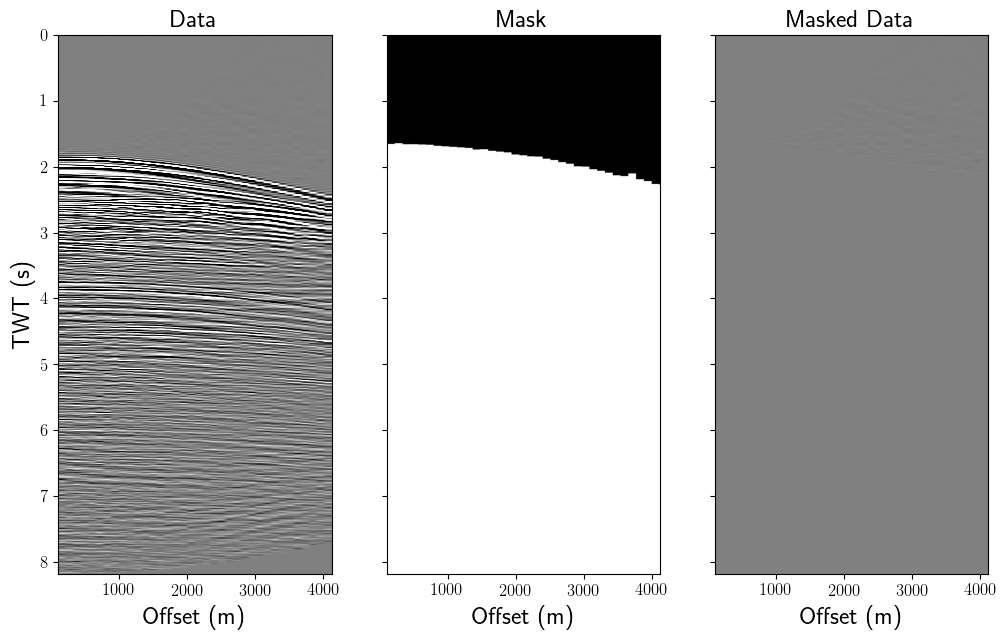

In [35]:
# Calculate time-space mask
maskt = mask(Rop.H @ data, mask_thresh)
 
fig, axs = plt.subplots(1, 3, figsize=(12, 7), sharey=True)
axs[0].imshow(data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('Data')
axs[0].axis('tight')

axs[1].imshow(maskt.T, cmap='gray', vmin=0, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_title('Mask')
axs[1].axis('tight')

axs[2].imshow((1-maskt[::nsub].T)*data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[2].set_xlabel('Offset (m)')
axs[2].set_title('Masked Data')
axs[2].axis('tight');

## FK mask design

Finally we design an FK mask that will be used to precondition all reconstruction processes, such that we ensure the reconstruct spectrum to lie within the expected signal cone.

In [36]:
mask_fk = fk_filter_design(f, ks, vel, fmax, critical=critical, koffset=koffset)
Mf = Diagonal(mask_fk.astype(np.complex).T.ravel(), dtype=np.complex)

/tmp/ipykernel_27183/2353276663.py:2: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Mf = Diagonal(mask_fk.astype(np.complex).T.ravel(), dtype=np.complex)


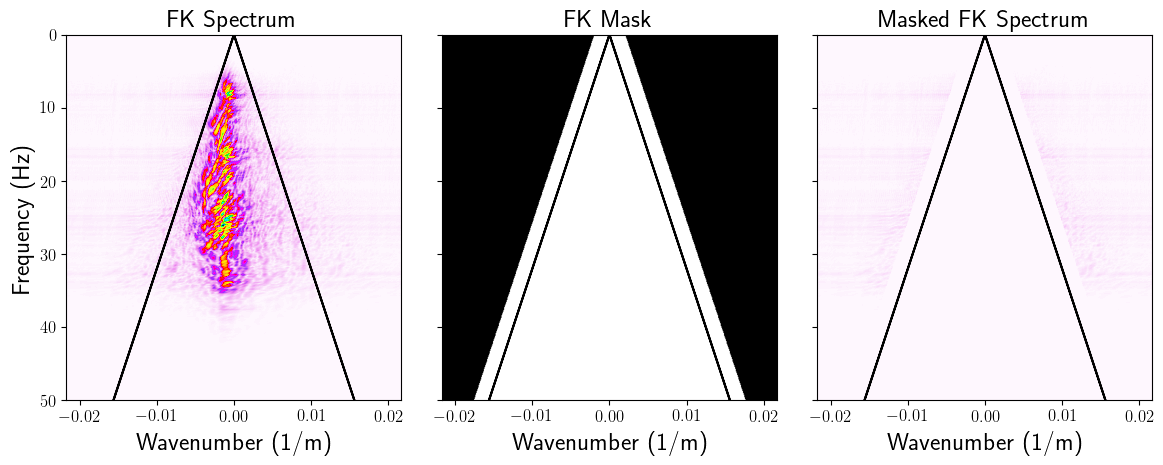

In [37]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 5))
axs[0].imshow(np.abs(np.fft.fftshift(D)).T[nfft_t//2:], cmap='gist_ncar_r',
              aspect='auto', vmin=0, vmax=1e1,
              extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nfft_t//2-1], f[0]))
axs[0].plot(f/vel, f,'k'), axs[0].plot(f/vel, -f,'k')
axs[0].set_xlim(-1/(2*dx), 1/(2*dx))
axs[0].set_xlabel('Wavenumber (1/m)')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_title('FK Spectrum')
axs[1].imshow(np.fft.ifftshift(mask_fk)[nfft_t//2:], cmap='gray',aspect='auto',
              extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nfft_t//2-1], f[0]))
axs[1].plot(f/vel, f,'k'), axs[1].plot(f/vel, -f,'k')
axs[1].set_xlim(-1/(2*dx), 1/(2*dx))
axs[1].set_xlabel('Wavenumber (1/m)')
axs[1].set_title('FK Mask')
axs[2].imshow(np.fft.fftshift((1-mask_fk)*np.abs(D).T)[nfft_t//2:], cmap='gist_ncar_r',
              aspect='auto', vmin=0, vmax=1e1,
              extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nfft_t//2-1], f[0]))
axs[2].plot(f/vel, f,'k'), axs[2].plot(f/vel, -f,'k')
axs[2].set_xlim(-1/(2*dx), 1/(2*dx))
axs[2].set_ylim(50, 0)
axs[2].set_xlabel('Wavenumber (1/m)')
axs[2].set_title('Masked FK Spectrum')
plt.tight_layout()

## Multi-channel slope estimation

We are now ready to estimate local slopes using our synthetically created multi-channel data. We will do it first for the fully sampled data (this will be our benchmark) and then for the sparsely sampled data.

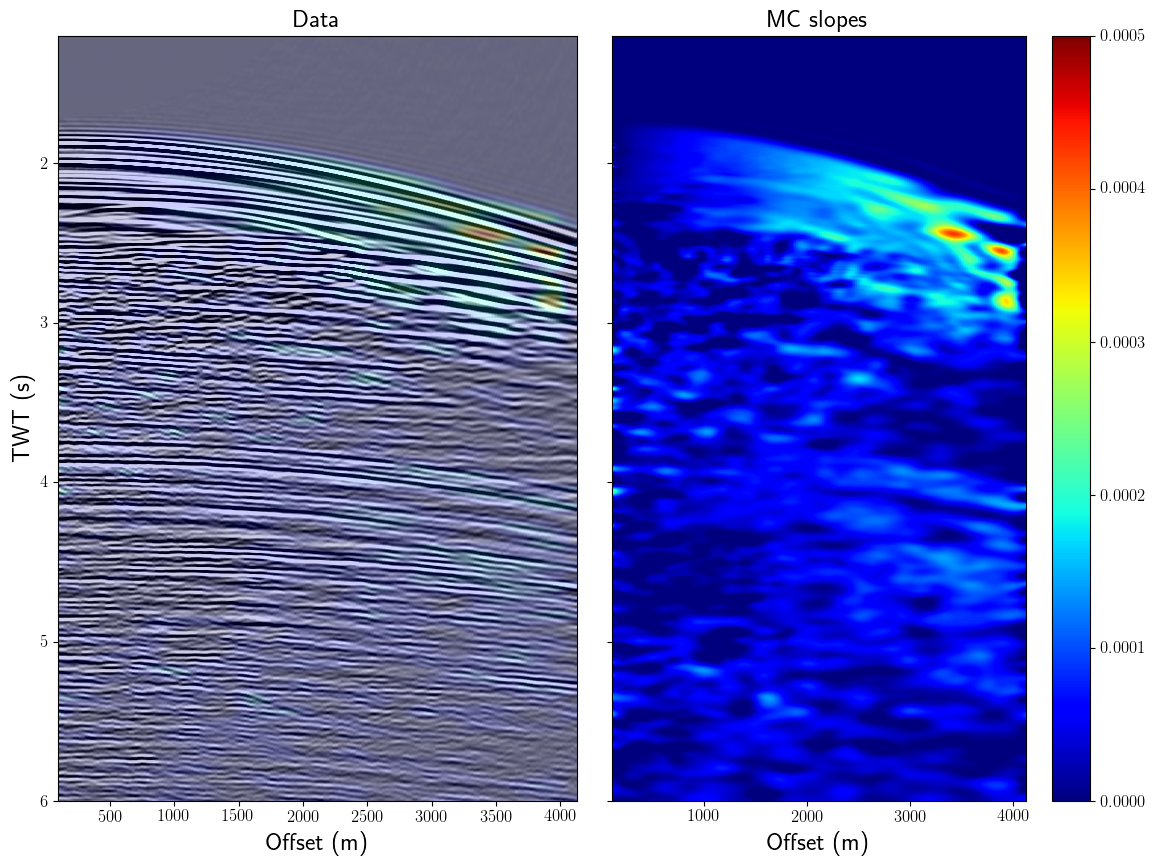

In [14]:
slope_mc = cp_asnumpy(multicomponent_slopes_inverse(cp_asarray(dataorig), dx, dt, 
                                                    graddata=cp_asarray(gradorig), reg=eps_slopeest,
                                                    **dict_slope_opt))
if apply_nmo:
    slope_mcnonmo = cp_asnumpy(multicomponent_slopes_inverse(cp_asarray(dataorignonmo), dx, dt, 
                                                             graddata=cp_asarray(gradorignonmo), reg=eps_slopeest,
                                                             **dict_slope_opt))

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(dataorig[:, 300:1500].T, cmap='gray', 
              vmin=-1, vmax=1, extent=(x[0], x[-1], t[1500], t[300]))
axs[0].imshow(cp_asnumpy(slope_mc)[300:1500], cmap='jet', 
              vmin=0, vmax=.5e-3, alpha=0.2, extent=(x[0], x[-1], t[1500], t[300]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('Data')
axs[0].axis('tight')
im = axs[1].imshow(slope_mc[300:1500], cmap='jet', 
                   vmin=0, vmax=.5e-3, extent=(x[0], x[-1], t[1500], t[300]))
fig.colorbar(im, ax=axs[1])
axs[1].set_title('MC slopes')
axs[1].set_xlabel('Offset (m)')
axs[1].axis('tight')
plt.tight_layout()

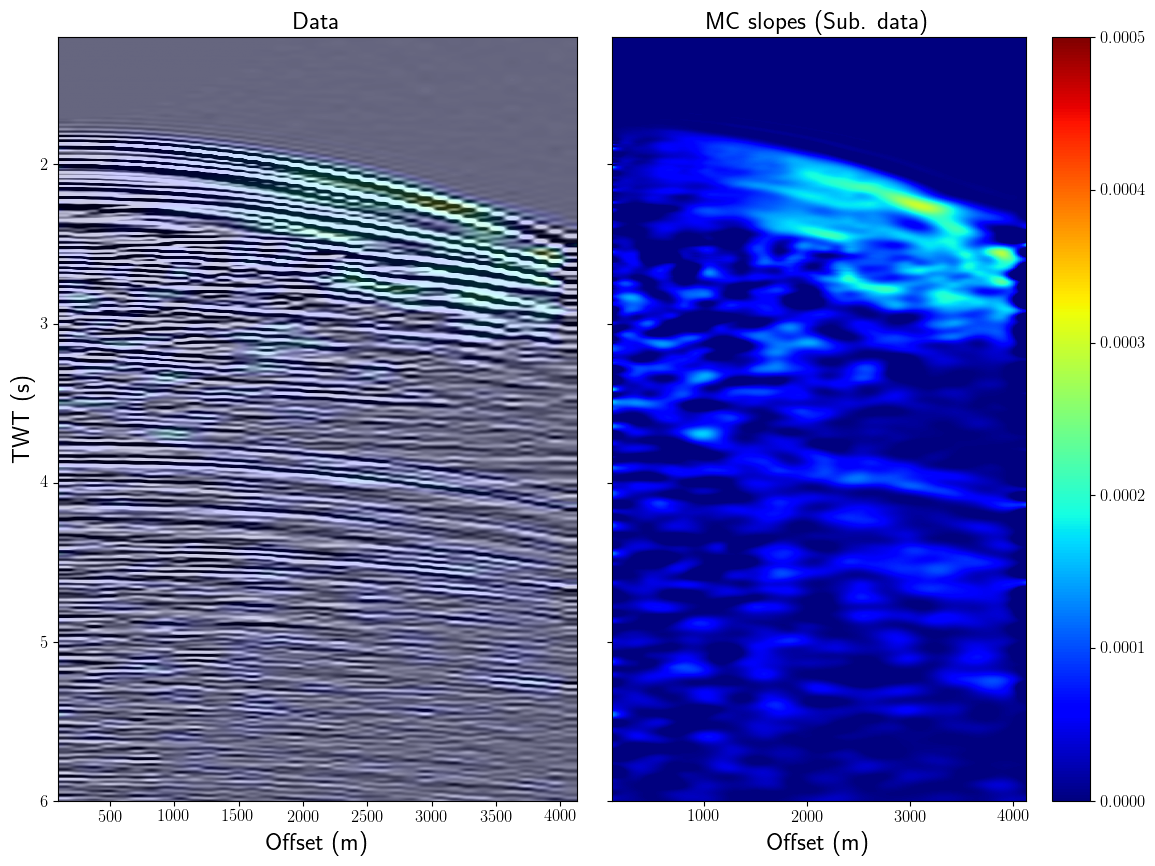

In [15]:
slope_mc1 = cp_asnumpy(multicomponent_slopes_inverse(Rop.H @ cp_asarray(data), dx, dt, 
                                                     graddata=Rop.H @ cp_asarray(grad), Rop=Rop,
                                                     reg=eps_slopeest,
                                                     **dict_slope_opt))

if apply_nmo:
    slope_mc1nonmo = cp_asnumpy(multicomponent_slopes_inverse(Rop.H @ cp_asarray(datanonmo), dx, dt, 
                                                              graddata=Rop.H @ cp_asarray(gradnonmo), Rop=Rop,
                                                              reg=eps_slopeest,
                                                              **dict_slope_opt))
    rcorr = np.array([sp.stats.pearsonr(slope_mcnonmo[:, ix], slope_mc1nonmo[:, ix])[0] for ix in range(nxorig)])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(data[:, 300:1500].T, cmap='gray', 
              vmin=-1, vmax=1, extent=(x[0], x[-1], t[1500], t[300]))
axs[0].imshow(cp_asnumpy(slope_mc1)[300:1500], cmap='jet', 
                         vmin=0, vmax=.5e-3, alpha=0.2, extent=(x[0], x[-1], t[1500], t[300]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('Data')
axs[0].axis('tight')
im = axs[1].imshow(slope_mc1[300:1500], cmap='jet',
                   vmin=0, vmax=.5e-3, extent=(x[0], x[-1], t[1500], t[300]))
fig.colorbar(im, ax=axs[1])
axs[1].set_title('MC slopes (Sub. data)')
axs[1].set_xlabel('Offset (m)')
axs[1].axis('tight')
plt.tight_layout()

## 2D single-channel interpolation with sparsity promoting inversion

In [16]:
F0op  = Rop * Fop.H * Mf
data0 = cp_asarray(data).ravel()
    
with pylops.disabled_ndarray_multiplication():
    pinv0, _, _ = fista(F0op, data0, niter=niter, eps=eps_fk, 
                        eigsdict=dict(niter=5, tol=1e-2), show=True)

dinv0 = cp_asnumpy(np.real(Fop.H * Mf * pinv0).reshape(nxorig, nt))

/home/ravasim/miniconda3/envs/mcslopes/lib/python3.10/site-packages/pylops/basicoperators/restriction.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  y[self.iavamask] = x.ravel()


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 73728 rows and 1048576 cols
eps = 1.000000e-03	tol = 1.000000e-10	niter = 200
alpha = 1.037655e+00	thresh = 5.188275e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -2.33e-03+2.85e-19j    1.074e+04   1.078e+04   1.585e+02
     2   -4.13e-03+5.05e-19j    4.919e+03   4.977e+03   8.670e+01
     3   -5.90e-03+7.22e-19j    2.082e+03   2.155e+03   6.911e+01
     4   -7.44e-03+9.11e-19j    8.045e+02   8.870e+02   5.270e+01
     5   -8.62e-03+1.06e-18j    2.635e+02   3.515e+02   3.924e+01
     6   -9.40e-03+1.15e-18j    6.160e+01   1.527e+02   2.828e+01
     7   -9.76e-03+1.20e-18j    8.728e+00   1.012e+02   1.910e+01
     8   -9.76e-03+1.20e-18j    9.088e+00   1.021e+02   1.138e+01
     9   -9.48e-03+1.16e-18j    1.692e+01   1.100e+02   5.245e+00
    10   -8.

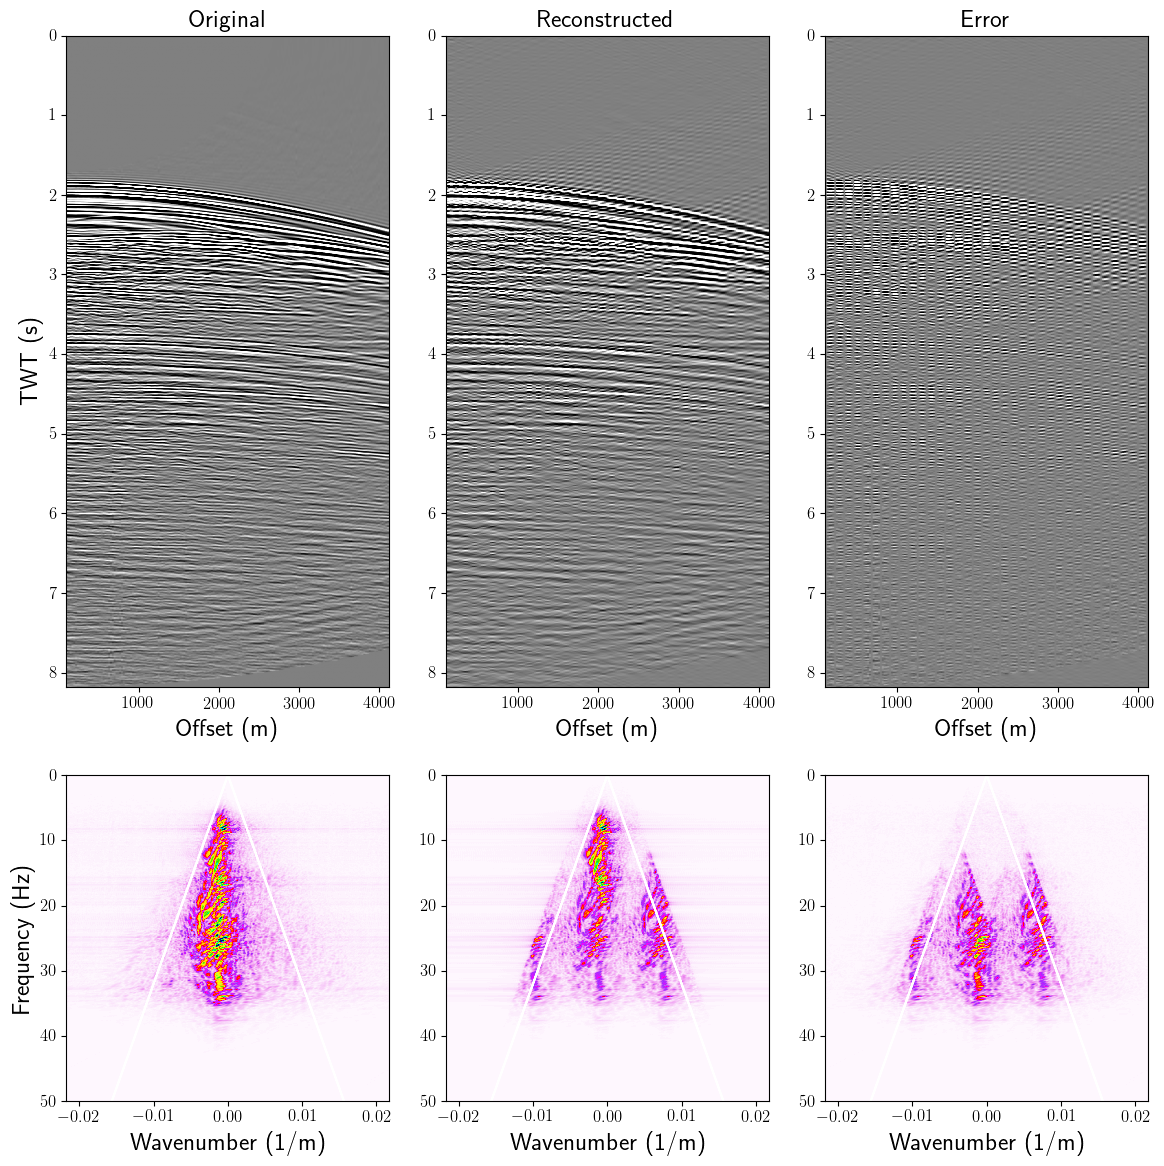

In [17]:
plot_reconstruction_2d(dataorig, dinv0, Fop, x, t, dx, f, ks, vel)

## 2D multi-channel interpolation with sparsity promoting inversion

In [18]:
if not use_secondder:
    # only first derivative
    F1op = VStack([Rop*Fop.H, 
                   sc1*Rop*Fop.H*D1op]) * Mf
    data1 = cp_asarray(np.concatenate((data.ravel(), sc1*grad.ravel()), axis=0))
else:
    # 1st and 2nd
    F1op = VStack([Rop*Fop.H, 
                   sc1*Rop*Fop.H*D1op, 
                   sc2*Rop*Fop.H*D2op]) * Mf
    data1 = cp_asarray(np.concatenate((data.ravel(), sc1*grad.ravel(), sc2*d2_dec), axis=0))

pinv1, _, _ = fista(F1op, data1, niter=niter, eps=eps_fk, 
                    eigsdict=dict(niter=5, tol=1e-2), show=True)

dinv1 = cp_asnumpy(np.real(Fop.H * Mf * pinv1).reshape(nxorig, nt))

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 147456 rows and 1048576 cols
eps = 1.000000e-03	tol = 1.000000e-10	niter = 200
alpha = 1.315062e-01	thresh = 6.575311e-05
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -2.95e-04+3.61e-20j    3.501e+04   3.502e+04   2.440e+01
     2   -5.82e-04+7.12e-20j    3.143e+04   3.144e+04   2.216e+01
     3   -9.39e-04+1.15e-19j    2.760e+04   2.761e+04   2.607e+01
     4   -1.36e-03+1.66e-19j    2.377e+04   2.379e+04   2.887e+01
     5   -1.83e-03+2.24e-19j    2.012e+04   2.016e+04   3.079e+01
     6   -2.35e-03+2.87e-19j    1.676e+04   1.680e+04   3.200e+01
     7   -2.90e-03+3.55e-19j    1.374e+04   1.379e+04   3.261e+01
     8   -3.48e-03+4.26e-19j    1.109e+04   1.114e+04   3.271e+01
     9   -4.08e-03+5.00e-19j    8.801e+03   8.864e+03   3.237e+01
    10   -4

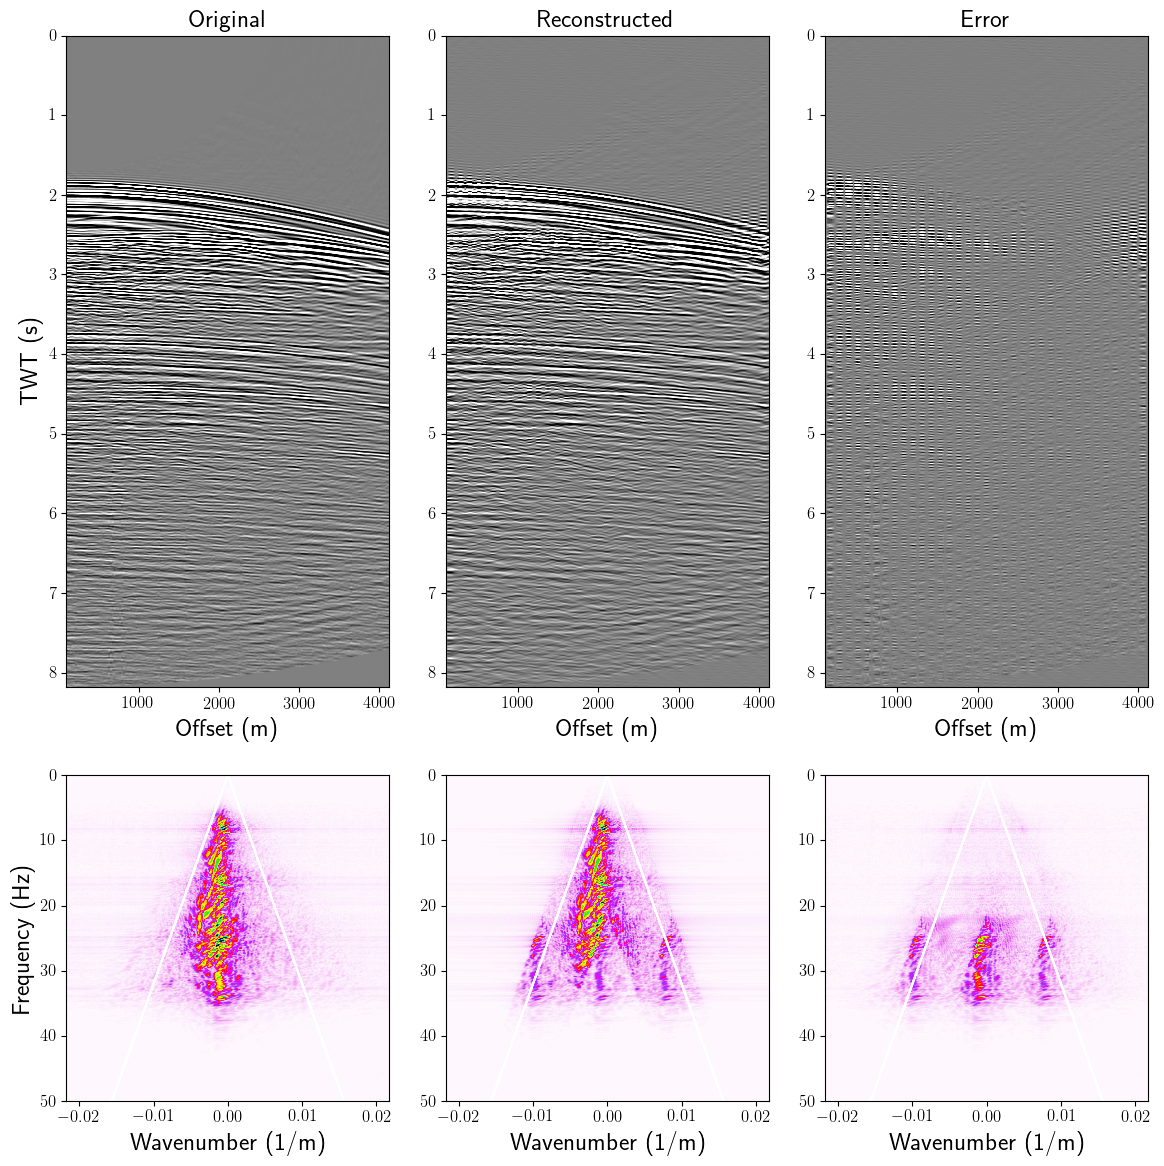

In [19]:
plot_reconstruction_2d(dataorig, dinv1, Fop, x, t, dx, f, ks, vel)

## 2D multi-channel interpolation with sparsity promoting inversion and local slopes regularization

In [20]:
# Let's start by setting the slope regularization term
D1op0 = FirstDerivative(dims=(nxorig, nt), axis=0, sampling=dx, order=5, edge=True, dtype="complex128")
D1op1 = FirstDerivative(dims=(nxorig, nt), axis=1, sampling=dt, order=5, edge=True, dtype="complex128")
slope_D1op1 = Diagonal(cp_asarray(slope_mc1).T.ravel()) * D1op1
SRegop = D1op0 + slope_D1op1

In [21]:
if not use_secondder:
    # only first
    F2op = VStack([Rop*Fop.H, 
                   sc1*Rop*Fop.H*D1op, 
                   eps_slopes * SRegop * Fop.H]) * Mf
    data2 = cp_asarray(np.concatenate((data.ravel(), sc1*grad.ravel(), np.zeros(nt*nxorig)), axis=0))
else:
    # 1st and 2nd
    F2op = VStack([Rop*Fop.H, 
                   sc1*Rop*Fop.H*D1op, 
                   sc2*Rop*Fop.H*D2op,
                   eps_slopes * SRegop * Fop.H]) * Mf
    data2 = cp_asarray(np.concatenate((data.ravel(), sc1*grad.ravel(), sc2*d2_dec, np.zeros(nt*nxorig)), axis=0))

pinv2, _, _ = fista(F2op, data2, niter=niter, eps=eps_fk, 
                    eigsdict=dict(niter=5, tol=1e-2), show=True)

dinv2 = cp_asnumpy(np.real(Fop.H * Mf * pinv2).reshape(nxorig, nt))

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 507904 rows and 1048576 cols
eps = 1.000000e-03	tol = 1.000000e-10	niter = 200
alpha = 1.286084e-01	thresh = 6.430422e-05
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -2.89e-04+3.53e-20j    3.513e+04   3.514e+04   2.386e+01
     2   -5.69e-04+6.97e-20j    3.173e+04   3.174e+04   2.141e+01
     3   -9.19e-04+1.12e-19j    2.815e+04   2.817e+04   2.496e+01
     4   -1.33e-03+1.63e-19j    2.463e+04   2.465e+04   2.744e+01
     5   -1.79e-03+2.19e-19j    2.131e+04   2.134e+04   2.911e+01
     6   -2.30e-03+2.82e-19j    1.826e+04   1.830e+04   3.016e+01
     7   -2.84e-03+3.48e-19j    1.553e+04   1.557e+04   3.070e+01
     8   -3.41e-03+4.18e-19j    1.310e+04   1.315e+04   3.084e+01
     9   -4.01e-03+4.91e-19j    1.099e+04   1.105e+04   3.063e+01
    10   -4

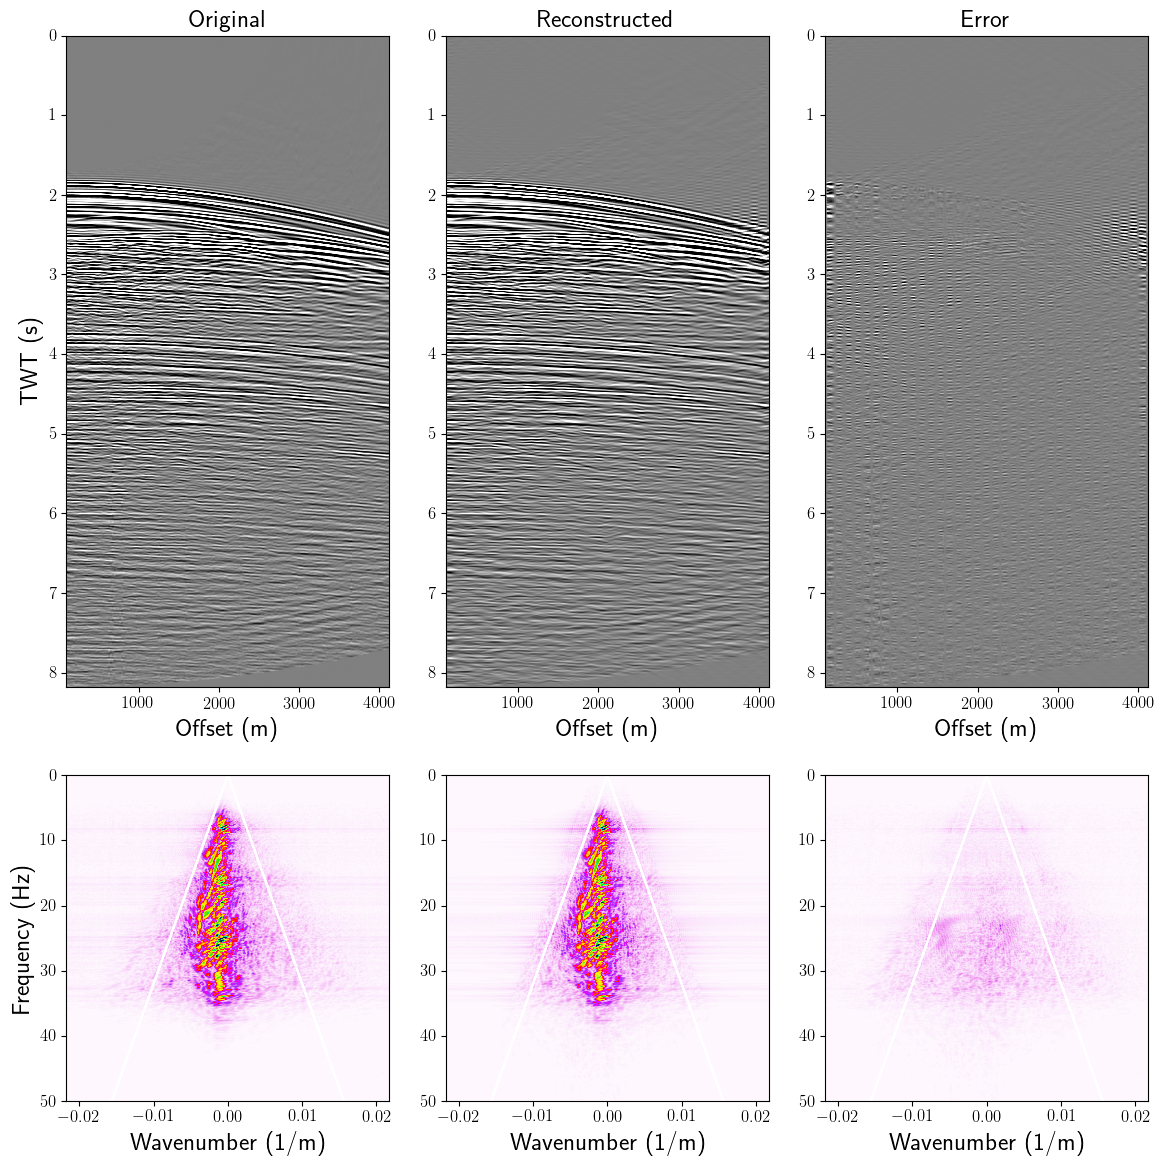

In [22]:
plot_reconstruction_2d(dataorig, cp_asnumpy(dinv2), Fop, x, t, dx, f, ks, vel)

## Restore data (aka INMO correction)

Finally, if NMO correction was applied to the data prior to interpolation, we restore the data to their original domain

In [23]:
if apply_nmo:
    dataorig = NMOOporig.div(dataorig.ravel()).reshape(nxorig, nt)
    data = NMOOporig.div(cp_asnumpy(Rop.H @ cp_asarray(data.ravel()))).reshape(nxorig, nt)
    dinv0 = NMOOporig.div(dinv0.ravel()).reshape(nxorig, nt)
    dinv1 = NMOOporig.div(dinv1.ravel()).reshape(nxorig, nt)
    dinv2 = NMOOporig.div(dinv2.ravel()).reshape(nxorig, nt)
    slope_mc = slope_mcnonmo
    slope_mc1 = slope_mc1nonmo
else:
    data = cp_asnumpy(Rop.H @ cp_asarray(data.ravel())).reshape(nxorig, nt)
                       
D = Fop * dataorig
Dsub = Fop * data
Dinv0 = Fop * dinv0
Dinv1 = Fop * dinv1
Dinv2 = Fop * dinv2

## Comparison

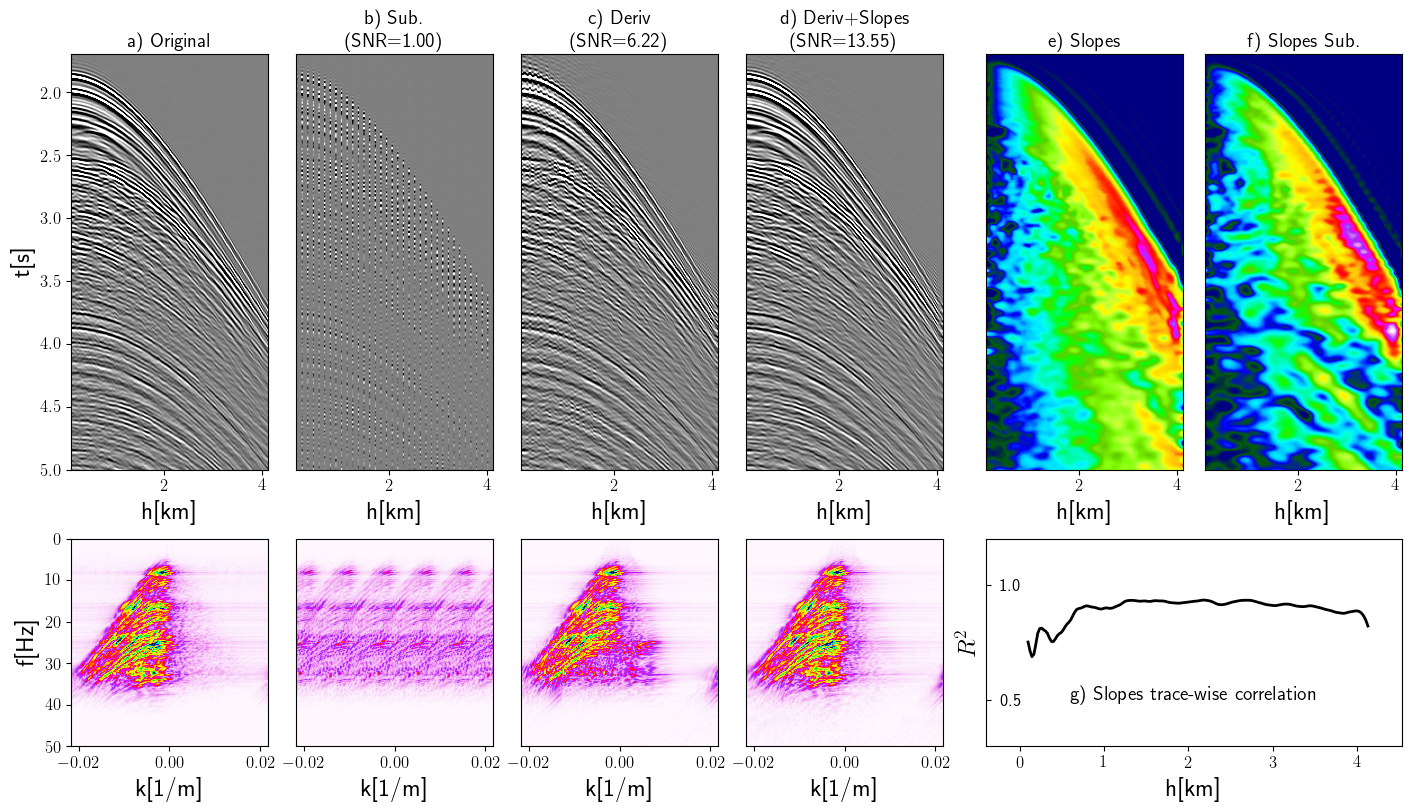

In [24]:
fig = plt.figure(constrained_layout=True, figsize=(14, 8))
axs = []
gs = fig.add_gridspec(3, 6)
axs.append(fig.add_subplot(gs[:2, 0]))
axs.append(fig.add_subplot(gs[:2, 1]))
axs.append(fig.add_subplot(gs[:2, 2]))
axs.append(fig.add_subplot(gs[:2, 3]))
axs.append(fig.add_subplot(gs[:2, 4]))
axs.append(fig.add_subplot(gs[:2, 5]))
axs.append(fig.add_subplot(gs[2:, 0]))
axs.append(fig.add_subplot(gs[2:, 1]))
axs.append(fig.add_subplot(gs[2:, 2]))
axs.append(fig.add_subplot(gs[2:, 3]))
axs.append(fig.add_subplot(gs[2:, 4:]))

axs[0].imshow(dataorig[:, 300:1500].T, cmap='gray', aspect='auto', vmin=-2, vmax=2, 
              extent=(x[0]/1000, x[-1]/1000, t[1500], t[300]))
axs[0].set_title('a) Original', fontsize=14)
axs[0].axis('tight')
axs[0].set_xlabel('h[km]')
axs[0].set_ylabel('t[s]')
axs[0].set_ylim(5, 1.7)

axs[1].imshow(data[:, 300:1500].T, cmap='gray', aspect='auto', vmin=-2, vmax=2, 
              extent=(x[0]/1000, x[-1]/1000, t[1500], t[300]))
axs[1].set_title(f'b) Sub. \n (SNR={snr(dataorig, data):.2f})', fontsize=14)
axs[1].axis('tight')
axs[1].set_ylim(5, 1.7)
axs[1].set_yticks([], [])
axs[1].set_xlabel('h[km]')

axs[2].imshow((maskt *dinv1)[:, 300:1500].T, cmap='gray', aspect='auto', vmin=-2, vmax=2, 
              extent=(x[0]/1000, x[-1]/1000, t[1500], t[300]))
axs[2].set_title(f'c) Deriv \n (SNR={snr(dataorig, maskt * dinv1):.2f})', fontsize=14)
axs[2].axis('tight')
axs[2].set_ylim(5, 1.7)
axs[2].set_yticks([], [])
axs[2].set_xlabel('h[km]')

axs[3].imshow((maskt *dinv2)[:, 300:1500].T, cmap='gray', aspect='auto', vmin=-2, vmax=2, 
              extent=(x[0]/1000, x[-1]/1000, t[1500], t[300]))
axs[3].set_title(f'd) Deriv+Slopes \n (SNR={snr(dataorig, maskt * dinv2):.2f})', fontsize=14)
axs[3].axis('tight')
axs[3].set_ylim(5, 1.7)
axs[3].set_yticks([], [])
axs[3].set_xlabel('h[km]')

axs[4].imshow(slope_mc[300:1500], cmap='gist_ncar', vmin=0, vmax=.8e-3, 
              extent=(x[0]/1000, x[-1]/1000, t[1500], t[300]))
axs[4].set_title(f'e) Slopes', fontsize=14);
axs[4].axis('tight')
axs[4].set_ylim(5, 1.7)
axs[4].set_yticks([], [])
axs[4].set_xlabel('h[km]')

axs[5].imshow(slope_mc1[300:1500], cmap='gist_ncar', vmin=0, vmax=.8e-3, 
              extent=(x[0]/1000, x[-1]/1000, t[1500], t[300]))
axs[5].set_title(f'f) Slopes Sub.', fontsize=14);
axs[5].axis('tight')
axs[5].set_ylim(5, 1.7)
axs[5].set_yticks([], [])
axs[5].set_xlabel('h[km]')

axs[6].imshow(np.fft.fftshift(np.abs(D).T)[nt//2:], cmap='gist_ncar_r',aspect='auto', vmin=0, vmax=5e0,
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[6].set_xlim(-1/(2*dx), 1/(2*dx));
axs[6].set_ylim(50, 0)
axs[6].set_ylabel('f[Hz]')
axs[6].set_xlabel('k[1/m]')

axs[7].imshow(np.fft.fftshift(np.abs(Dsub).T)[nt//2:], cmap='gist_ncar_r',aspect='auto', vmin=0, vmax=5e0,
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[7].set_xlim(-1/(2*dx), 1/(2*dx));
axs[7].set_ylim(50, 0)
axs[7].set_yticks([], [])
axs[7].set_xlabel('k[1/m]')

axs[8].imshow(np.fft.fftshift(np.abs(Dinv1).T)[nt//2:], cmap='gist_ncar_r',aspect='auto', vmin=0, vmax=5e0,
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[8].set_xlim(-1/(2*dx), 1/(2*dx));
axs[8].set_ylim(50, 0)
axs[8].set_yticks([], [])
axs[8].set_xlabel('k[1/m]')

axs[9].imshow(np.fft.fftshift(np.abs(Dinv2).T)[nt//2:], cmap='gist_ncar_r',aspect='auto', vmin=0, vmax=5e0,
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[9].set_xlim(-1/(2*dx), 1/(2*dx));
axs[9].set_ylim(50, 0)
axs[9].set_yticks([], [])
axs[9].set_xlabel('k[1/m]')

axs[10].plot(xorig/1000 , rcorr, 'k', lw=2)
axs[10].text(0.6, 0.5, 'g) Slopes trace-wise correlation', fontsize=14)
axs[10].set_xlim(-0.4, x[-1]/1000+0.4)
axs[10].set_ylim(0.3,1.2)
axs[10].set_xlabel('h[km]')
axs[10].set_ylabel(r'$R^2$')
axs[10].set_yticks([0.5, 1.], [0.5, 1.])
axs[10].tick_params(axis="y",direction="in", pad=-25)

plt.savefig(f'../../figs/gom/Reconstuction_sub{nsub}_nmo{apply_nmo}_usesecond{use_secondder}.eps');